## Импорт необходимых библиотек

In [1]:
import nltk
import torch
import pymorphy2
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from pymorphy2.shapes import is_punctuation
from transformers import BertForTokenClassification
from torch.utils.data import Dataset, DataLoader, random_split

## Предобработка данных

#### Импорт файла с ручной разметкой

In [2]:
df = pd.read_excel('shuffled_excel_LAST.xlsx').drop_duplicates()
df.columns = ["Title", "Words", "Tag"]
df.head()

,Title,Words,Tag
0,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",Межкомнатная,O
1,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",дверь,O
2,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",GLAtum,CMPN
3,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",X6,MDL
4,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",Серый,COL_START


#### Демонстрация несбалансированности классов

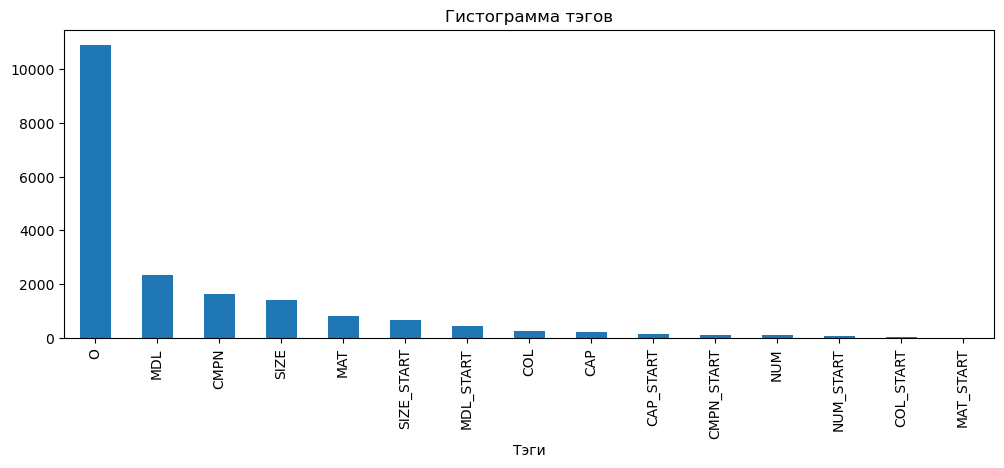

In [3]:
df['Tag'].value_counts().plot.bar(figsize=(12, 4))
plt.title('Гистограмма тэгов')
plt.xlabel('Тэги')
plt.show()

#### Приведение датафрейма к нужной форме

In [4]:
first_dataframe = df.groupby('Title')['Tag'].apply(list).reset_index()
words = df.groupby('Title')['Words'].apply(list).reset_index()['Words']
first_dataframe['Words'] = words
first_dataframe

,Title,Tag,Words
0,"0,4 m z=160 20° дисковый долбяк кл. А Р18*","[SIZE_START, SIZE, O, O, O, O, O, O, O]","[0,4, m, z=160, 20°, дисковый, долбяк, кл, А, ..."
1,"0,8 m z=80 20° дисковый долбяк кл. В Р18*","[SIZE_START, SIZE, O, O, O, O, O, O, MDL]","[0,8, m, z=80, 20°, дисковый, долбяк, кл, В, Р18]"
2,"0204.АЛЮМИНИЕВЫЕ РАДИАТОРЫ 80Х500 ""B2""","[MAT, O, SIZE, MDL]","[0204.АЛЮМИНИЕВЫЕ, РАДИАТОРЫ, 80Х500, B2]"
3,1.1.5 Кольцо бетонное КС 10.3. серия 3.900.1-14,"[O, O, MAT, O, O, O, MDL]","[1.1.5, Кольцо, бетонное, КС, 10.3., серия, 3...."
4,1.1.83 Плита перекрытия колодца ПП 10.2 (усилен.),"[MDL, O, O, O, O, MDL, O]","[1.1.83, Плита, перекрытия, колодца, ПП, 10.2,..."
...,...,...,...
2492,лампа энергосберегающая Tdm Sp E27 20W 6500 10...,"[O, O, CMPN, O, O, O, O, O, O, O, O, MDL]","[лампа, энергосберегающая, Tdm, Sp, E27, 20W, ..."
2493,мМисУзРоНК. Что скрывают зеркала. Калинина Н.Д.,"[O, O, O, O, O, O]","[мМисУзРоНК, Что, скрывают, зеркала, Калинина,..."
2494,"сверло по металлу, ЗУБР, ТЕХНИК, 4-29605-109-7.5","[O, O, O, CMPN, MDL_START, MDL]","[сверло, по, металлу, ЗУБР, ТЕХНИК, 4-29605-10..."
2495,услуги грузчиков и разнорабочих,"[O, O, O, O]","[услуги, грузчиков, и, разнорабочих]"


#### Класс, который объединяет в себе Vocabulary и Vectorizer

In [5]:
class VocabVectorize:
    pad = "<PAD>"
    unk = "<UNK>"
    titles = []
    
    def __init__(self, titles, tags):
        titles = titles.apply(lambda x: self.tokenize(x)).explode().value_counts().index  #уникальные названия
        max_len = max([len(val) for val in titles]) 
        self.alphabet = [VocabVectorize.pad, VocabVectorize.unk, *titles] #создание словаря, с учетом <UNK>, <PAD>
        self.max_len = max_len
        text2seq = {word: i for i, word in enumerate(self.alphabet)} 
        self.seq2text = {i: word for i, word in enumerate(self.alphabet)}
        unknown_idx =  text2seq[VocabVectorize.unk]
        self.text2seq = defaultdict(lambda: unknown_idx,  text2seq)
        tags = tags.explode().value_counts().index
        self.alphabet_tags = [*tags]
        self.tag2seq = {word: i for i, word in enumerate(self.alphabet_tags)}
        self.seq2tag = {i: word for i, word in enumerate(self.alphabet_tags)}
        
    def __len__(self):
        return len(self.alphabet)
    
    def tokenize(self, text):
        return list(filter(lambda y: not is_punctuation(y) and y != '``', nltk.word_tokenize(text.lower())))
    
    #преобразует название товара в вектор, который дополняется пэддингами до длины максимального названия
    def encode(self, text):
        no_pad = list(map(lambda x: self.text2seq[x], self.tokenize(text)))
        len_pad = self.max_len - len(no_pad)
        attention_mask = torch.tensor([1] * len(no_pad) + [0] * len_pad).long()
        return torch.tensor(no_pad + [self.text2seq['<PAD>']]*len_pad), attention_mask
    
    #преобразует вектор в название товара, убирая все пэддинги
    def decode(self, encode_text):
        with_pad = list(map(self.seq2text.get, encode_text.tolist()))
        return ' '.join(list(filter(lambda x: x != '<PAD>', with_pad))) 
    
    #преобразует тэг в вектор
    def tag_encode(self, tags):
        encoded_tag = torch.tensor(list(map(self.tag2seq.get, tags + ['O']*(self.max_len - len(tags)))))
        return encoded_tag
    
    #преобразует векторное представление тэгов в символьное
    def tag_decode(self, encode_tag, encode_text):
        decoded_tag = list(map(self.seq2tag.get, encode_tag[encode_text != 0].tolist()))
        return decoded_tag

In [6]:
vocab = VocabVectorize(first_dataframe['Title'], first_dataframe['Tag'])
vocab.max_len

33

#### Класс, который нужен для дальнейшего использования DataLoader

In [7]:
class DataSet(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
        self.max_len = self.vocab.max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        x, attention_mask = self.vocab.encode(self.data.iloc[i]['Title'])  
        y = self.vocab.tag_encode(self.data.iloc[i]['Tag'])
        return x, y, attention_mask

In [8]:
dataset = DataSet(first_dataframe, vocab)

#### Разбиение датасетов на train, val, test

In [9]:
ratio = 0.2
num_test =  int(ratio * len(dataset))
num_train = len(dataset) - num_test
train_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_test])

num_valid =  int(ratio * len(train_dataset))
num_train = len(train_dataset) - num_valid
train_dataset, valid_dataset = random_split(train_dataset, lengths=[num_train, num_valid])

In [10]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

#### Определение девайса, на котором будут происходить дальнейшие вычисления

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Дообучение модели BertForTokenClassification

#### Импорт модели

In [12]:
class BertModel(torch.nn.Module):
    def __init__(self, unique_labels):
        super(BertModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=unique_labels)

    def forward(self, input_id, mask, label):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)
        return output

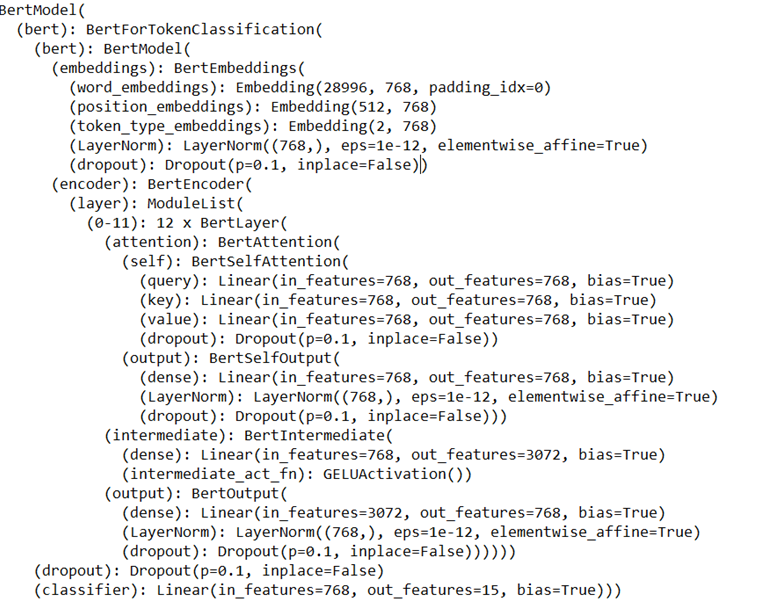

#### Цикл обучения

In [13]:
def train_loop(model, train_dataloader, val_dataloader, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    if use_cuda:
        model = model.cuda()
        
    train_losses = []
    train_acc = []
    train_f1 = []
    val_losses = []
    val_acc = []
    val_f1 = []
    for epoch_num in range(EPOCHS):
        total_acc_train = 0
        total_loss_train = 0
        model.train()
        true = []
        pred = []
        for train_data, train_label, attention_mask in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = attention_mask.to(device)
            input_id = train_data.to(device)
            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)
            for i in range(logits.shape[0]):
                predictions = logits[i].argmax(dim=1)
                pred.append(predictions)
                true.append(train_label[i])
                acc = (predictions == train_label[i]).float().mean()
                total_acc_train += acc
                total_loss_train += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(total_loss_train / (len(train_dataloader) * batch_size))
        train_acc.append(total_acc_train.cpu() / (len(train_dataloader) * batch_size))
        f1 = f1_score(torch.concat(true).cpu(), torch.concat(pred).cpu(), average='macro')
        train_f1.append(f1)
        model.eval()
        total_acc_val = 0
        total_loss_val = 0
        true = []
        pred = []
        for val_data, val_label, attention_mask in val_dataloader:
            val_label = val_label.to(device)
            mask = attention_mask.to(device)
            input_id = val_data.to(device)
            loss, logits = model(input_id, mask, val_label)
            for i in range(logits.shape[0]):
                predictions = logits[i].argmax(dim=1)
                pred.append(predictions)
                true.append(val_label[i])
                acc = (predictions == val_label[i]).float().mean()
                total_acc_val += acc
                total_loss_val += loss.item()
        val_accuracy = total_acc_val.cpu() / (len(val_dataloader) * batch_size)
        val_loss = total_loss_val / (len(val_dataloader) * batch_size)
        f1 = f1_score(torch.concat(true).cpu(), torch.concat(pred).cpu(), average='macro')
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)
        val_f1.append(f1)
        print(f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / (len(train_dataloader) * batch_size): .3f} | Accuracy: {total_acc_train / (len(train_dataloader) * batch_size): .3f} | F1 Score {train_f1[-1]: .3f} | Val_Loss: {val_loss: .3f} | Val Accuracy: {val_accuracy: .3f} | Val F1 Score: {f1: .3f}')
        
    return train_losses, train_acc, train_f1, val_losses, val_acc, val_f1

In [14]:
LEARNING_RATE = 0.00005
EPOCHS = 15
unique_labels = len(vocab.tag2seq.keys())

#### Обучение 5 моделей (для дополнительной разметки)

In [15]:
def train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
    model = BertModel(unique_labels)
    train_losses, train_acc, train_f1, val_losses, val_acc, val_f1 = train_loop(model, train_loader, valid_loader, batch_size)
    torch.save(model, file_name)
    torch.cuda.empty_cache()
    del train_loader  
    del valid_loader
    del model
    return train_losses, train_acc, train_f1, val_losses, val_acc, val_f1

In [16]:
train_losses_1, train_acc_1, train_f1_1, val_losses_1, val_acc_1, val_f1_1 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_1.pth')
train_losses_2, train_acc_2, train_f1_2, val_losses_2, val_acc_2, val_f1_2 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_2.pth')
train_losses_3, train_acc_3, train_f1_3, val_losses_3, val_acc_3, val_f1_3 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_3.pth')
train_losses_4, train_acc_4, train_f1_4, val_losses_4, val_acc_4, val_f1_4 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_4.pth')
train_losses_5, train_acc_5, train_f1_5, val_losses_5, val_acc_5, val_f1_5 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_5.pth')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.437 | Accuracy:  0.894 | F1 Score  0.083 | Val_Loss:  0.322 | Val Accuracy:  0.908 | Val F1 Score:  0.112


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:21<00:00,  9.22it/s]


Epochs: 2 | Loss:  0.307 | Accuracy:  0.909 | F1 Score  0.143 | Val_Loss:  0.279 | Val Accuracy:  0.915 | Val F1 Score:  0.161


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.95it/s]


Epochs: 3 | Loss:  0.248 | Accuracy:  0.925 | F1 Score  0.218 | Val_Loss:  0.247 | Val Accuracy:  0.928 | Val F1 Score:  0.278


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.71it/s]


Epochs: 4 | Loss:  0.191 | Accuracy:  0.942 | F1 Score  0.362 | Val_Loss:  0.224 | Val Accuracy:  0.934 | Val F1 Score:  0.369


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.86it/s]


Epochs: 5 | Loss:  0.143 | Accuracy:  0.956 | F1 Score  0.473 | Val_Loss:  0.239 | Val Accuracy:  0.933 | Val F1 Score:  0.431


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.82it/s]


Epochs: 6 | Loss:  0.108 | Accuracy:  0.966 | F1 Score  0.557 | Val_Loss:  0.236 | Val Accuracy:  0.938 | Val F1 Score:  0.503


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.73it/s]


Epochs: 7 | Loss:  0.081 | Accuracy:  0.975 | F1 Score  0.643 | Val_Loss:  0.231 | Val Accuracy:  0.941 | Val F1 Score:  0.527


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.57it/s]


Epochs: 8 | Loss:  0.059 | Accuracy:  0.981 | F1 Score  0.701 | Val_Loss:  0.252 | Val Accuracy:  0.942 | Val F1 Score:  0.557


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.72it/s]


Epochs: 9 | Loss:  0.049 | Accuracy:  0.985 | F1 Score  0.773 | Val_Loss:  0.260 | Val Accuracy:  0.944 | Val F1 Score:  0.586


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.63it/s]


Epochs: 10 | Loss:  0.041 | Accuracy:  0.987 | F1 Score  0.801 | Val_Loss:  0.257 | Val Accuracy:  0.949 | Val F1 Score:  0.611


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.63it/s]


Epochs: 11 | Loss:  0.032 | Accuracy:  0.990 | F1 Score  0.838 | Val_Loss:  0.279 | Val Accuracy:  0.948 | Val F1 Score:  0.611


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.67it/s]


Epochs: 12 | Loss:  0.028 | Accuracy:  0.991 | F1 Score  0.851 | Val_Loss:  0.279 | Val Accuracy:  0.946 | Val F1 Score:  0.590


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:22<00:00,  8.66it/s]


Epochs: 13 | Loss:  0.026 | Accuracy:  0.992 | F1 Score  0.867 | Val_Loss:  0.255 | Val Accuracy:  0.949 | Val F1 Score:  0.625


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.63it/s]


Epochs: 14 | Loss:  0.021 | Accuracy:  0.993 | F1 Score  0.896 | Val_Loss:  0.288 | Val Accuracy:  0.944 | Val F1 Score:  0.639


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.60it/s]


Epochs: 15 | Loss:  0.016 | Accuracy:  0.995 | F1 Score  0.930 | Val_Loss:  0.307 | Val Accuracy:  0.950 | Val F1 Score:  0.692


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.441 | Accuracy:  0.897 | F1 Score  0.081 | Val_Loss:  0.322 | Val Accuracy:  0.903 | Val F1 Score:  0.110


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.55it/s]


Epochs: 2 | Loss:  0.303 | Accuracy:  0.910 | F1 Score  0.167 | Val_Loss:  0.275 | Val Accuracy:  0.915 | Val F1 Score:  0.197


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.59it/s]


Epochs: 3 | Loss:  0.237 | Accuracy:  0.930 | F1 Score  0.266 | Val_Loss:  0.235 | Val Accuracy:  0.931 | Val F1 Score:  0.285


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.39it/s]


Epochs: 4 | Loss:  0.171 | Accuracy:  0.949 | F1 Score  0.432 | Val_Loss:  0.217 | Val Accuracy:  0.940 | Val F1 Score:  0.482


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.57it/s]


Epochs: 5 | Loss:  0.123 | Accuracy:  0.963 | F1 Score  0.559 | Val_Loss:  0.238 | Val Accuracy:  0.936 | Val F1 Score:  0.518


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.60it/s]


Epochs: 6 | Loss:  0.088 | Accuracy:  0.973 | F1 Score  0.667 | Val_Loss:  0.236 | Val Accuracy:  0.942 | Val F1 Score:  0.522


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.58it/s]


Epochs: 7 | Loss:  0.062 | Accuracy:  0.981 | F1 Score  0.766 | Val_Loss:  0.239 | Val Accuracy:  0.945 | Val F1 Score:  0.598


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.57it/s]


Epochs: 8 | Loss:  0.046 | Accuracy:  0.986 | F1 Score  0.801 | Val_Loss:  0.254 | Val Accuracy:  0.947 | Val F1 Score:  0.639


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 9 | Loss:  0.034 | Accuracy:  0.989 | F1 Score  0.855 | Val_Loss:  0.261 | Val Accuracy:  0.948 | Val F1 Score:  0.693


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 10 | Loss:  0.032 | Accuracy:  0.990 | F1 Score  0.880 | Val_Loss:  0.291 | Val Accuracy:  0.944 | Val F1 Score:  0.677


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 11 | Loss:  0.024 | Accuracy:  0.993 | F1 Score  0.912 | Val_Loss:  0.258 | Val Accuracy:  0.947 | Val F1 Score:  0.670


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.55it/s]


Epochs: 12 | Loss:  0.017 | Accuracy:  0.995 | F1 Score  0.943 | Val_Loss:  0.294 | Val Accuracy:  0.944 | Val F1 Score:  0.672


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.46it/s]


Epochs: 13 | Loss:  0.017 | Accuracy:  0.995 | F1 Score  0.939 | Val_Loss:  0.306 | Val Accuracy:  0.948 | Val F1 Score:  0.706


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.52it/s]


Epochs: 14 | Loss:  0.020 | Accuracy:  0.995 | F1 Score  0.940 | Val_Loss:  0.299 | Val Accuracy:  0.948 | Val F1 Score:  0.709


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 15 | Loss:  0.015 | Accuracy:  0.995 | F1 Score  0.955 | Val_Loss:  0.300 | Val Accuracy:  0.948 | Val F1 Score:  0.727


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.424 | Accuracy:  0.894 | F1 Score  0.081 | Val_Loss:  0.337 | Val Accuracy:  0.887 | Val F1 Score:  0.111


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 2 | Loss:  0.304 | Accuracy:  0.910 | F1 Score  0.144 | Val_Loss:  0.278 | Val Accuracy:  0.913 | Val F1 Score:  0.161


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.54it/s]


Epochs: 3 | Loss:  0.248 | Accuracy:  0.924 | F1 Score  0.209 | Val_Loss:  0.243 | Val Accuracy:  0.928 | Val F1 Score:  0.264


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.49it/s]


Epochs: 4 | Loss:  0.191 | Accuracy:  0.943 | F1 Score  0.342 | Val_Loss:  0.243 | Val Accuracy:  0.929 | Val F1 Score:  0.324


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 5 | Loss:  0.141 | Accuracy:  0.957 | F1 Score  0.470 | Val_Loss:  0.223 | Val Accuracy:  0.942 | Val F1 Score:  0.435


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.50it/s]


Epochs: 6 | Loss:  0.109 | Accuracy:  0.967 | F1 Score  0.563 | Val_Loss:  0.235 | Val Accuracy:  0.942 | Val F1 Score:  0.511


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.46it/s]


Epochs: 7 | Loss:  0.083 | Accuracy:  0.975 | F1 Score  0.632 | Val_Loss:  0.233 | Val Accuracy:  0.944 | Val F1 Score:  0.554


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.47it/s]


Epochs: 8 | Loss:  0.063 | Accuracy:  0.980 | F1 Score  0.705 | Val_Loss:  0.244 | Val Accuracy:  0.944 | Val F1 Score:  0.568


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 9 | Loss:  0.049 | Accuracy:  0.985 | F1 Score  0.778 | Val_Loss:  0.257 | Val Accuracy:  0.946 | Val F1 Score:  0.599


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.14it/s]


Epochs: 10 | Loss:  0.039 | Accuracy:  0.987 | F1 Score  0.806 | Val_Loss:  0.286 | Val Accuracy:  0.948 | Val F1 Score:  0.622


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.23it/s]


Epochs: 11 | Loss:  0.032 | Accuracy:  0.990 | F1 Score  0.859 | Val_Loss:  0.284 | Val Accuracy:  0.947 | Val F1 Score:  0.665


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.37it/s]


Epochs: 12 | Loss:  0.027 | Accuracy:  0.992 | F1 Score  0.870 | Val_Loss:  0.283 | Val Accuracy:  0.947 | Val F1 Score:  0.679


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.42it/s]


Epochs: 13 | Loss:  0.023 | Accuracy:  0.993 | F1 Score  0.903 | Val_Loss:  0.270 | Val Accuracy:  0.949 | Val F1 Score:  0.649


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.44it/s]


Epochs: 14 | Loss:  0.019 | Accuracy:  0.994 | F1 Score  0.923 | Val_Loss:  0.309 | Val Accuracy:  0.948 | Val F1 Score:  0.652


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.40it/s]


Epochs: 15 | Loss:  0.020 | Accuracy:  0.994 | F1 Score  0.921 | Val_Loss:  0.305 | Val Accuracy:  0.948 | Val F1 Score:  0.674


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.461 | Accuracy:  0.893 | F1 Score  0.075 | Val_Loss:  0.328 | Val Accuracy:  0.907 | Val F1 Score:  0.107


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.15it/s]


Epochs: 2 | Loss:  0.321 | Accuracy:  0.906 | F1 Score  0.131 | Val_Loss:  0.284 | Val Accuracy:  0.915 | Val F1 Score:  0.157


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:25<00:00,  7.79it/s]


Epochs: 3 | Loss:  0.261 | Accuracy:  0.922 | F1 Score  0.203 | Val_Loss:  0.287 | Val Accuracy:  0.911 | Val F1 Score:  0.186


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:25<00:00,  7.69it/s]


Epochs: 4 | Loss:  0.199 | Accuracy:  0.940 | F1 Score  0.340 | Val_Loss:  0.244 | Val Accuracy:  0.928 | Val F1 Score:  0.344


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.04it/s]


Epochs: 5 | Loss:  0.151 | Accuracy:  0.954 | F1 Score  0.462 | Val_Loss:  0.222 | Val Accuracy:  0.940 | Val F1 Score:  0.447


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.38it/s]


Epochs: 6 | Loss:  0.114 | Accuracy:  0.964 | F1 Score  0.541 | Val_Loss:  0.208 | Val Accuracy:  0.943 | Val F1 Score:  0.505


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.42it/s]


Epochs: 7 | Loss:  0.088 | Accuracy:  0.972 | F1 Score  0.650 | Val_Loss:  0.230 | Val Accuracy:  0.944 | Val F1 Score:  0.514


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.42it/s]


Epochs: 8 | Loss:  0.070 | Accuracy:  0.978 | F1 Score  0.687 | Val_Loss:  0.248 | Val Accuracy:  0.949 | Val F1 Score:  0.597


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.44it/s]


Epochs: 9 | Loss:  0.050 | Accuracy:  0.984 | F1 Score  0.766 | Val_Loss:  0.250 | Val Accuracy:  0.944 | Val F1 Score:  0.622


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.43it/s]


Epochs: 10 | Loss:  0.041 | Accuracy:  0.987 | F1 Score  0.800 | Val_Loss:  0.254 | Val Accuracy:  0.946 | Val F1 Score:  0.655


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.44it/s]


Epochs: 11 | Loss:  0.034 | Accuracy:  0.989 | F1 Score  0.862 | Val_Loss:  0.274 | Val Accuracy:  0.949 | Val F1 Score:  0.657


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.44it/s]


Epochs: 12 | Loss:  0.028 | Accuracy:  0.992 | F1 Score  0.879 | Val_Loss:  0.281 | Val Accuracy:  0.946 | Val F1 Score:  0.654


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.40it/s]


Epochs: 13 | Loss:  0.026 | Accuracy:  0.992 | F1 Score  0.872 | Val_Loss:  0.275 | Val Accuracy:  0.946 | Val F1 Score:  0.659


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.39it/s]


Epochs: 14 | Loss:  0.023 | Accuracy:  0.993 | F1 Score  0.911 | Val_Loss:  0.281 | Val Accuracy:  0.951 | Val F1 Score:  0.703


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.24it/s]


Epochs: 15 | Loss:  0.020 | Accuracy:  0.994 | F1 Score  0.909 | Val_Loss:  0.281 | Val Accuracy:  0.947 | Val F1 Score:  0.669


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.434 | Accuracy:  0.894 | F1 Score  0.080 | Val_Loss:  0.323 | Val Accuracy:  0.906 | Val F1 Score:  0.093


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.47it/s]


Epochs: 2 | Loss:  0.310 | Accuracy:  0.910 | F1 Score  0.152 | Val_Loss:  0.271 | Val Accuracy:  0.916 | Val F1 Score:  0.169


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.34it/s]


Epochs: 3 | Loss:  0.243 | Accuracy:  0.927 | F1 Score  0.233 | Val_Loss:  0.235 | Val Accuracy:  0.930 | Val F1 Score:  0.306


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.22it/s]


Epochs: 4 | Loss:  0.182 | Accuracy:  0.945 | F1 Score  0.383 | Val_Loss:  0.235 | Val Accuracy:  0.934 | Val F1 Score:  0.423


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.36it/s]


Epochs: 5 | Loss:  0.140 | Accuracy:  0.958 | F1 Score  0.506 | Val_Loss:  0.224 | Val Accuracy:  0.939 | Val F1 Score:  0.454


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.47it/s]


Epochs: 6 | Loss:  0.104 | Accuracy:  0.967 | F1 Score  0.569 | Val_Loss:  0.229 | Val Accuracy:  0.941 | Val F1 Score:  0.497


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.48it/s]


Epochs: 7 | Loss:  0.077 | Accuracy:  0.976 | F1 Score  0.674 | Val_Loss:  0.245 | Val Accuracy:  0.941 | Val F1 Score:  0.537


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.49it/s]


Epochs: 8 | Loss:  0.058 | Accuracy:  0.982 | F1 Score  0.725 | Val_Loss:  0.256 | Val Accuracy:  0.941 | Val F1 Score:  0.582


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.48it/s]


Epochs: 9 | Loss:  0.046 | Accuracy:  0.986 | F1 Score  0.775 | Val_Loss:  0.246 | Val Accuracy:  0.945 | Val F1 Score:  0.615


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.37it/s]


Epochs: 10 | Loss:  0.038 | Accuracy:  0.988 | F1 Score  0.833 | Val_Loss:  0.259 | Val Accuracy:  0.947 | Val F1 Score:  0.619


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.44it/s]


Epochs: 11 | Loss:  0.030 | Accuracy:  0.991 | F1 Score  0.861 | Val_Loss:  0.265 | Val Accuracy:  0.948 | Val F1 Score:  0.669


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.31it/s]


Epochs: 12 | Loss:  0.027 | Accuracy:  0.992 | F1 Score  0.869 | Val_Loss:  0.268 | Val Accuracy:  0.946 | Val F1 Score:  0.664


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.16it/s]


Epochs: 13 | Loss:  0.022 | Accuracy:  0.993 | F1 Score  0.911 | Val_Loss:  0.292 | Val Accuracy:  0.950 | Val F1 Score:  0.689


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.04it/s]


Epochs: 14 | Loss:  0.020 | Accuracy:  0.994 | F1 Score  0.914 | Val_Loss:  0.279 | Val Accuracy:  0.948 | Val F1 Score:  0.660


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.27it/s]


Epochs: 15 | Loss:  0.020 | Accuracy:  0.994 | F1 Score  0.913 | Val_Loss:  0.275 | Val Accuracy:  0.949 | Val F1 Score:  0.644


#### Результаты обучения каждой из 5 моделей

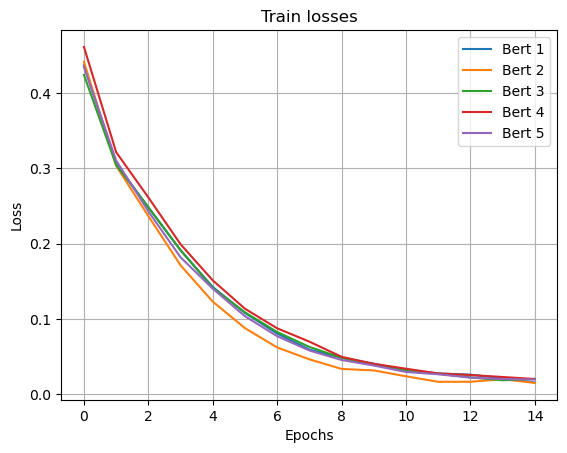

In [17]:
plt.plot(train_losses_1, label='Bert 1')
plt.plot(train_losses_2, label='Bert 2')
plt.plot(train_losses_3, label='Bert 3')
plt.plot(train_losses_4, label='Bert 4')
plt.plot(train_losses_5, label='Bert 5')
plt.title('Train losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

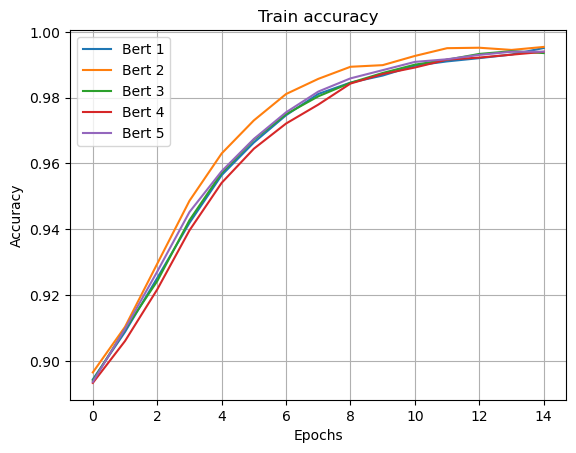

In [18]:
plt.plot(list(map(lambda x: x.cpu(), train_acc_1)), label='Bert 1')
plt.plot(list(map(lambda x: x.cpu(), train_acc_2)), label='Bert 2')
plt.plot(list(map(lambda x: x.cpu(), train_acc_3)), label='Bert 3')
plt.plot(list(map(lambda x: x.cpu(), train_acc_4)), label='Bert 4')
plt.plot(list(map(lambda x: x.cpu(), train_acc_5)), label='Bert 5')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

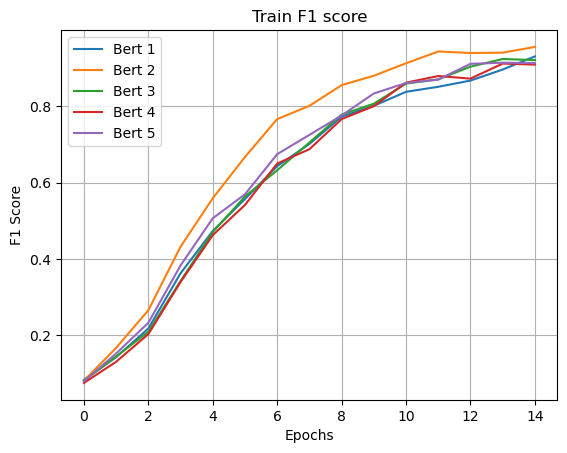

In [19]:
plt.plot(train_f1_1, label='Bert 1')
plt.plot(train_f1_2, label='Bert 2')
plt.plot(train_f1_3, label='Bert 3')
plt.plot(train_f1_4, label='Bert 4')
plt.plot(train_f1_5, label='Bert 5')
plt.title('Train F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

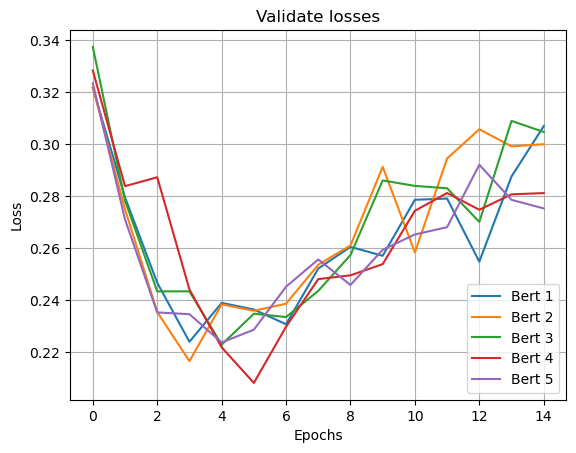

In [20]:
plt.plot(val_losses_1, label='Bert 1')
plt.plot(val_losses_2, label='Bert 2')
plt.plot(val_losses_3, label='Bert 3')
plt.plot(val_losses_4, label='Bert 4')
plt.plot(val_losses_5, label='Bert 5')
plt.title('Validate losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

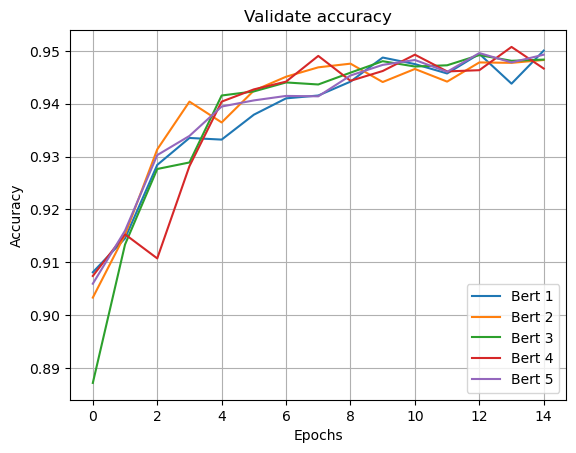

In [21]:
plt.plot(list(map(lambda x: x.cpu(), val_acc_1)), label='Bert 1')
plt.plot(list(map(lambda x: x.cpu(), val_acc_2)), label='Bert 2')
plt.plot(list(map(lambda x: x.cpu(), val_acc_3)), label='Bert 3')
plt.plot(list(map(lambda x: x.cpu(), val_acc_4)), label='Bert 4')
plt.plot(list(map(lambda x: x.cpu(), val_acc_5)), label='Bert 5')
plt.title('Validate accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

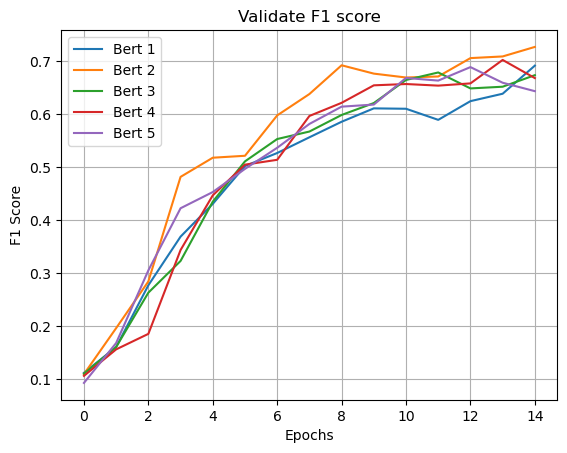

In [22]:
plt.plot(val_f1_1, label='Bert 1')
plt.plot(val_f1_2, label='Bert 2')
plt.plot(val_f1_3, label='Bert 3')
plt.plot(val_f1_4, label='Bert 4')
plt.plot(val_f1_5, label='Bert 5')
plt.title('Validate F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [23]:
def bert_test(model, test_dataloader, batch_size):
    model.eval()
    total_acc_test = 0
    total_loss_test = 0
    true = []
    pred = []
    for test_data, test_label, attention_mask in test_dataloader:
        test_label = test_label.to(device)
        mask = attention_mask.to(device)
        input_id = test_data.to(device)
        loss, logits = model(input_id, mask, test_label)
        for i in range(logits.shape[0]):
            predictions = logits[i].argmax(dim=1)
            true.append(predictions)
            pred.append(test_label[i])
            acc = (predictions == test_label[i]).float().mean()
            total_acc_test += acc
            total_loss_test += loss.item()
    test_accuracy = total_acc_test / (len(test_dataloader) * batch_size)
    test_loss = total_loss_test / (len(test_dataloader) * batch_size)
    f1 = f1_score(torch.concat(true).cpu(), torch.concat(pred).cpu(), average='macro')

    print(f'TEST | Loss: {test_loss: .3f} | Accuracy: {test_accuracy: .3f} | F1 Score: {f1: .3f}')

In [25]:
model_1 = torch.load('model_1.pth').to(device)
bert_test(model_1, test_loader, batch_size)

TEST | Loss:  0.322 | Accuracy:  0.948 | F1 Score:  0.677


## Дополнительная разметка данных

In [26]:
big = pd.read_excel('for_bert_excel.xlsx')

####  Разметка новых данных методом голосования моделей

In [27]:
titles = []
tags_list = []
model_1 = torch.load('model_1.pth').to(device)
model_2 = torch.load('model_2.pth').to(device)
model_3 = torch.load('model_3.pth').to(device)
model_4 = torch.load('model_4.pth').to(device)
model_5 = torch.load('model_5.pth').to(device)

with torch.no_grad():
    for title in tqdm(big['Title']):
        token, att_mask = vocab.encode(title)
        preds = []
        for model in [model_1, model_2, model_3, model_4, model_5]:
            #делаем предсказание на каждой из моделей
            loss, pred = model(token.unsqueeze(0).to(device), att_mask.unsqueeze(0).to(device), torch.zeros(1, len(token)).long().to(device))
            preds.append(pred.argmax(dim=2)[0])
        preds = torch.concat(preds).reshape(5, -1)
        preds = torch.mode(preds, dim=0).values  #для каждого токена выбираем самый популярный из 5 
        tag = vocab.tag_decode(preds, token)
        titles.append(title)
        tags_list.append(tag)
        torch.cuda.empty_cache()   #очищение кэша, чтобы оперативная память не переполнялась
print(titles[0], tags_list[0])

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [16:20<00:00, 15.30it/s]

Лотки и плиты теплотрассы П24д-8 ['O', 'O', 'O', 'O', 'MDL']


#### Визуализация решения задачи NER

In [28]:
def visualize_ner(words, tags):
    colors = {
        'MDL': '\033[31m',    #слово из каждой категории выводится таким цветом, как его тэг
        'CMPN': '\033[4m',
        'SIZE': '\033[32m',
        'MAT': '\033[33m',
        'COL': '\033[34m',
        'CAP': '\033[35m',
        'NUM': '\033[36m'
    }
    blank = '\033[0m'         #после выделения слова определенным цветом форматирование обнуляется, чтобы не окрасить лишнее
    res = ''.join([v + k + blank + '\n' for k, v in colors.items()])
    for i in range(len(words)):
        for token, label in zip(words[i], tags[i]):
            tag = label.split('_')[0]
            res += colors.get(tag, blank) + token + blank + ' '
        res += '\n'
    print(res)

In [29]:
custom_title = ['Насос дренажный PATRIOT FQ1200N  1200 Вт, 18000 л/час',
                '1.1.83 Плита перекрытия колодца ПП 10.2 (усилен.)',
                'Плита перекрытия П1 по серии ИС-01-04, вып.2',
                'фанера большеформатная ФК и ФСФ',
                'Краска для бетона Monopol Color цвет синий'
               ]
tokens = list(map(lambda x: vocab.tokenize(x), custom_title))
X = torch.concat(list(map(lambda x: vocab.encode(x)[0], custom_title))).reshape(len(custom_title), -1)
mask = torch.concat(list(map(lambda x: vocab.encode(x)[1], custom_title))).reshape(len(custom_title), -1)
y = torch.zeros(len(custom_title), len(X[0])).long()
_, pred = model_1(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [30]:
_, pred = model_2(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [31]:
_, pred = model_3(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [32]:
_, pred = model_4(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [33]:
_, pred = model_5(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



#### Преобразование файла с дополнительной разметкой в нужный формат

In [34]:
new_dataset = pd.DataFrame({'Title':titles, 'Tag':tags_list})
new_dataset['Words'] = new_dataset['Title'].apply(lambda x: vocab.tokenize(x))
new_dataset

,Title,Tag,Words
0,Лотки и плиты теплотрассы П24д-8,"[O, O, O, O, MDL]","[лотки, и, плиты, теплотрассы, п24д-8]"
1,"Кисть плоская STAYER ""LASUR - LUX"", деревянная...","[O, O, CMPN, O, O, MAT, O, O, MAT, MDL]","[кисть, плоская, stayer, lasur, lux, деревянна..."
2,"Плита перекрытия П1 по серии ИС-01-04, вып.2","[O, O, O, O, O, MDL, MDL]","[плита, перекрытия, п1, по, серии, ис-01-04, в..."
3,Диск пильный по дереву EUROTEX 190х32х36 зубь...,"[O, O, O, O, O, O, O, O, O, O]","[диск, пильный, по, дереву, eurotex, 190х32х36..."
4,Сверло по металлу ЗУБР 4-29605-191-17.5 быстро...,"[O, O, O, CMPN, O, O, MAT, O, O, O, SIZE, SIZE...","[сверло, по, металлу, зубр, 4-29605-191-17.5, ..."
...,...,...,...
14995,"Кисть КМ-55, ГОСТ, L щет.= 89 мм, полиамидная ...","[O, O, O, O, O, SIZE, SIZE, O, O]","[кисть, км-55, гост, l, щет.=, 89, мм, полиами..."
14996,Краска для бетона Monopol Color цвет синий фас...,"[O, O, O, CMPN_START, CMPN, O, COL, O, SIZE_ST...","[краска, для, бетона, monopol, color, цвет, си..."
14997,"Колодезные кольца КС 10-9, КС 15-9, КС 20-9","[O, MDL, MDL_START, MDL, MDL, MDL, MDL_START, O]","[колодезные, кольца, кс, 10-9, кс, 15-9, кс, 2..."
14998,"Ножовка по дереву ЗУБР (пила) ЗУБР 355 мм, 1 п...","[O, O, O, CMPN, O, CMPN, SIZE_START, SIZE, O, O]","[ножовка, по, дереву, зубр, пила, зубр, 355, м..."


In [35]:
new_dataset.to_excel('bert_made.xlsx', index=False)

In [36]:
new_dataset = pd.read_excel('bert_made.xlsx')
new_dataset['Tag'] = new_dataset['Tag'].apply(eval)
new_dataset['Words'] = new_dataset['Words'].apply(eval)
new_dataset

,Title,Tag,Words
0,Лотки и плиты теплотрассы П24д-8,"[O, O, O, O, MDL]","[лотки, и, плиты, теплотрассы, п24д-8]"
1,"Кисть плоская STAYER ""LASUR - LUX"", деревянная...","[O, O, CMPN, O, O, MAT, O, O, MAT, MDL]","[кисть, плоская, stayer, lasur, lux, деревянна..."
2,"Плита перекрытия П1 по серии ИС-01-04, вып.2","[O, O, O, O, O, MDL, MDL]","[плита, перекрытия, п1, по, серии, ис-01-04, в..."
3,Диск пильный по дереву EUROTEX 190х32х36 зубь...,"[O, O, O, O, O, O, O, O, O, O]","[диск, пильный, по, дереву, eurotex, 190х32х36..."
4,Сверло по металлу ЗУБР 4-29605-191-17.5 быстро...,"[O, O, O, CMPN, O, O, MAT, O, O, O, SIZE, SIZE...","[сверло, по, металлу, зубр, 4-29605-191-17.5, ..."
...,...,...,...
14995,"Кисть КМ-55, ГОСТ, L щет.= 89 мм, полиамидная ...","[O, O, O, O, O, SIZE, SIZE, O, O]","[кисть, км-55, гост, l, щет.=, 89, мм, полиами..."
14996,Краска для бетона Monopol Color цвет синий фас...,"[O, O, O, CMPN_START, CMPN, O, COL, O, SIZE_ST...","[краска, для, бетона, monopol, color, цвет, си..."
14997,"Колодезные кольца КС 10-9, КС 15-9, КС 20-9","[O, MDL, MDL_START, MDL, MDL, MDL, MDL_START, O]","[колодезные, кольца, кс, 10-9, кс, 15-9, кс, 2..."
14998,"Ножовка по дереву ЗУБР (пила) ЗУБР 355 мм, 1 п...","[O, O, O, CMPN, O, CMPN, SIZE_START, SIZE, O, O]","[ножовка, по, дереву, зубр, пила, зубр, 355, м..."


In [37]:
visualize_ner(new_dataset['Words'][14995:].values, new_dataset['Tag'][14995:].values)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
кисть км-55 гост l щет.= 89 мм полиамидная обойма 
краска для бетона monopol color цвет синий фасовка 1 л 
колодезные кольца кс 10-9 кс 15-9 кс 20-9 
ножовка по дереву зубр пила зубр 355 мм 1 полотно 
каналы и тоннели сборные железобетонные из лотковых элементов лотки серия 3.006.1-8 изделие лк75.210.120-3 



In [38]:
new_dataset['HandMade'] = 0        #для semi-supervised learning нужно отметить, какие данные были созданы автоматически,
first_dataframe['HandMade'] = 1    #а какие вручную

#### Создание нового "большого" датасета, в котором объединены размеченный вручную и размеченный с помощью 5 моделей BertForTokenClassification

In [39]:
big_dataframe = pd.concat([first_dataframe, new_dataset], ignore_index=True)
big_dataframe.shape

(17497, 4)

#### Демонстрация несбалансированности классов в увеличенном датасете

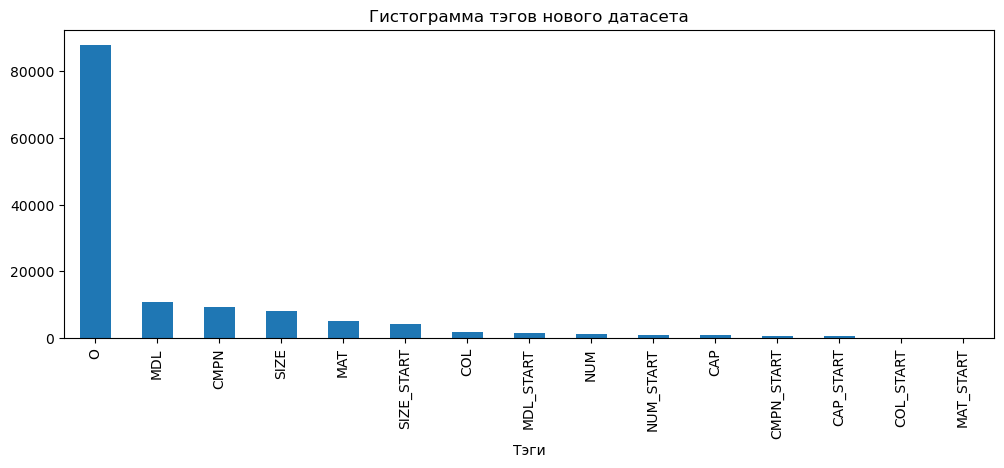

In [40]:
big_dataframe['Tag'].explode().value_counts().plot.bar(figsize=(12, 4))
plt.title('Гистограмма тэгов нового датасета')
plt.xlabel('Тэги')
plt.show()

In [41]:
vocab = VocabVectorize(big_dataframe['Title'], big_dataframe['Tag'])
vocab.max_len

39

#### Адаптированный для semi-supervised learning класс DataSet

In [42]:
class DataSet_hm(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
        self.max_len = self.vocab.max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        hm = self.data.iloc[i]['HandMade']
        x, attention_mask = self.vocab.encode(self.data.iloc[i]['Title'])
        y = torch.tensor(list(map(self.vocab.tag2seq.get, self.data.iloc[i]['Tag'] + ['O']*(self.max_len - len(self.data.iloc[i]['Tag'])))))
        return x, y, attention_mask, hm

big_dataset = DataSet_hm(big_dataframe, vocab)

## Обучение модели со слоем BI-LSTM

#### Архитектура модели

In [43]:
class NER_LSTM_Model(nn.Module):
    def __init__(self, emb_size, input_size, hidden_size, num_layers, n_classes, input_len):
        super().__init__()
        self.embed = nn.Embedding(input_size + 1, emb_size)
        self.bilstm = nn.LSTM(emb_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.norm = nn.BatchNorm1d(input_len)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.sigmoid = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        out = self.embed(x)
        out = self.dropout(out)
        out, _ = self.bilstm(out)
        out = self.norm(out)
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

#### Создание кастомного класса ошибки, который можно применять на данных, классы которых несбалансированы

In [44]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

$$ \begin{aligned}
C E_i & =-\log p_i \\
e^{-C E_i} & =e^{\log p_i}=p_i \\
F L_i & =\alpha\left(1-p_i\right)^\gamma \cdot \log p_i=\alpha\left(1-e^{-C E_i}\right)^\gamma \cdot C E_i
\end{aligned} $$

#### Функция для обучения второй и третьей моделей

In [45]:
def semi_train(model, loader, loss_function, optimizer):
    model.train()
    epoch_loss = 0
    epoch_predict = []
    epoch_label = []
    N = 0
    beta = 0.2
    for inputs, labels, _, hm in tqdm(loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device)).permute(0, 2, 1)
        loss = 0
        if hm.sum():
            loss += loss_function(outputs[hm.bool()], labels[hm.bool()].to(device)) 
        if ~hm.sum():           #если данные размечены автоматически, то ошибка, связанная с ними, учитывается только на 20%
            loss += beta * loss_function(outputs[~hm.bool()], labels[~hm.bool()].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        mask = labels != vocab.text2seq.get(VocabVectorize.pad)
        epoch_predict.append(outputs.argmax(dim=1)[mask])
        epoch_label.append(labels[mask])
    return epoch_loss / len(loader), accuracy_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu()), f1_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu(), average='macro')

#### Функция для тестирования второй и третьей моделей

In [46]:
def semi_test(model, loader, loss_function):
    with torch.no_grad():
        model.eval()
        epoch_predict = []
        epoch_label = []
        for inputs, labels, _, _ in tqdm(loader):
            outputs = model(inputs.to(device)).permute(0, 2, 1)
            mask = labels != vocab.text2seq.get(VocabVectorize.pad)
            epoch_predict.append(outputs.argmax(dim=1)[mask])
            epoch_label.append(labels[mask])
        return accuracy_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu()), f1_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu(), average='macro')

In [47]:
input_size = len(vocab.alphabet)
emb_size = 200
hidden_size = 100
num_layers = 3
input_len = vocab.max_len
n_classes = len(vocab.alphabet_tags)

model = NER_LSTM_Model(emb_size, input_size, hidden_size, num_layers, n_classes, input_len).to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [48]:
ratio = 0.2
num_test =  int(ratio * len(big_dataset))
num_train = len(big_dataset) - num_test
train_dataset, test_dataset = random_split(big_dataset, lengths=[num_train, num_test])

num_valid =  int(ratio * len(train_dataset))
num_train = len(train_dataset) - num_valid
train_dataset, valid_dataset = random_split(train_dataset, lengths=[num_train, num_valid])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

#### Обучение и тестирование второй модели

In [49]:
num_epochs = 10
train_losses = []
train_accs = []
train_f1s = []
valid_accs = []
valid_f1s = []
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = semi_train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    valid_acc, valid_f1 = semi_test(model, loader=valid_loader, loss_function=criterion)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f}, Train Acc {train_acc:.6f}, Train F1 {train_f1:.6f}')
    print(f'Valid Acc {valid_acc:.6f}, Valid F1 {valid_f1:.6f}')
    print('---')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    torch.cuda.empty_cache()
    
test_acc, test_f1 = semi_test(model=model, loader=test_loader, loss_function=criterion)
print(test_acc, test_f1)

100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 138.93it/s]


Epoch 0
Train Loss 0.136922, Train Acc 0.287167, Train F1 0.238585
Valid Acc 0.516321, Valid F1 0.443854
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 142.80it/s]


Epoch 1
Train Loss 0.076930, Train Acc 0.588748, Train F1 0.526762
Valid Acc 0.629184, Valid F1 0.608648
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 141.81it/s]


Epoch 2
Train Loss 0.052213, Train Acc 0.672569, Train F1 0.664583
Valid Acc 0.673859, Valid F1 0.654074
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 141.41it/s]


Epoch 3
Train Loss 0.037318, Train Acc 0.713769, Train F1 0.713271
Valid Acc 0.693914, Valid F1 0.710512
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 141.87it/s]


Epoch 4
Train Loss 0.028508, Train Acc 0.748656, Train F1 0.742782
Valid Acc 0.719502, Valid F1 0.714758
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 141.52it/s]


Epoch 5
Train Loss 0.022706, Train Acc 0.766320, Train F1 0.765701
Valid Acc 0.748824, Valid F1 0.727624
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 142.22it/s]


Epoch 6
Train Loss 0.018966, Train Acc 0.786846, Train F1 0.781955
Valid Acc 0.720609, Valid F1 0.718334
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 141.87it/s]


Epoch 7
Train Loss 0.015608, Train Acc 0.800724, Train F1 0.785322
Valid Acc 0.727109, Valid F1 0.732468
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 143.09it/s]


Epoch 8
Train Loss 0.013938, Train Acc 0.809015, Train F1 0.801551
Valid Acc 0.738313, Valid F1 0.732730
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 142.68it/s]


Epoch 9
Train Loss 0.013091, Train Acc 0.821740, Train F1 0.804767
Valid Acc 0.744260, Valid F1 0.750431
---


100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:03<00:00, 118.56it/s]

0.7449343130705857 0.7562602466753127


#### Визуализация результатов второй модели

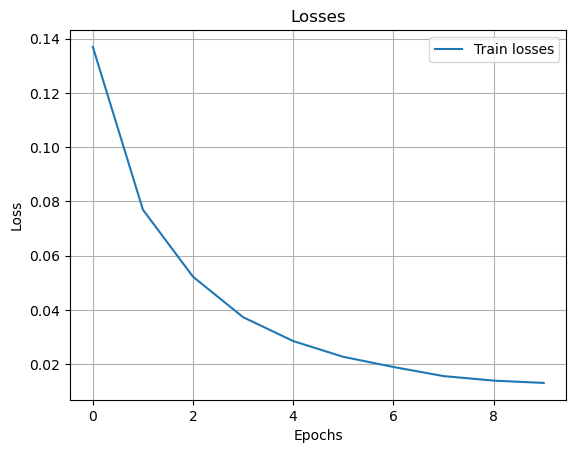

In [50]:
plt.plot(train_losses, label='Train losses')
plt.grid()
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

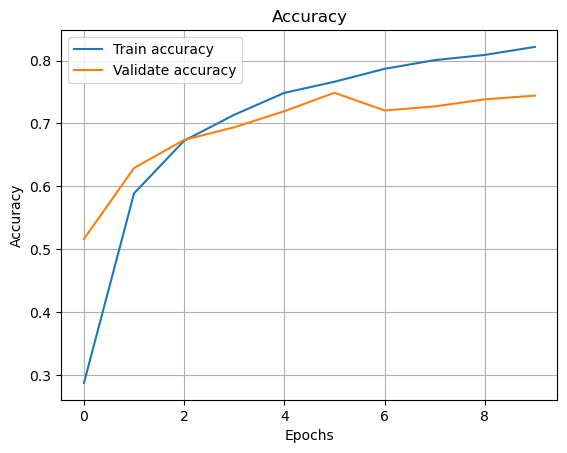

In [51]:
plt.plot(train_accs, label='Train accuracy')
plt.plot(valid_accs, label='Validate accuracy')
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

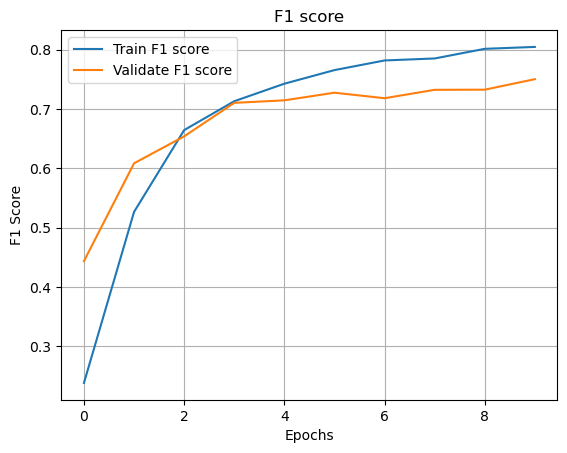

In [52]:
plt.plot(train_f1s, label='Train F1 score')
plt.plot(valid_f1s, label='Validate F1 score')
plt.grid()
plt.title('F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [53]:
torch.save(model, 'final_lstm_model.pth') #Модель и её веса сохраняются для дальнейшего использования, чтобы снова не ждать весь процесс обучения

In [54]:
tokens = list(map(lambda x: vocab.tokenize(x), custom_title))
X = torch.concat(list(map(lambda x: vocab.encode(x)[0], custom_title))).reshape(len(custom_title), -1)
pred = model(X.to(device)).argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



## Обучение модели со слоем BI-GRU

#### Архитектура модели

In [55]:
class NER_GRU_Model(nn.Module):
    def __init__(self, emb_size, input_size, hidden_size, num_layers, n_classes, input_len):
        super().__init__()
        self.embed = nn.Embedding(input_size + 1, emb_size)
        self.bilstm = nn.GRU(emb_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.norm = nn.BatchNorm1d(input_len)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.sigmoid = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        out = self.embed(x)
        out = self.dropout(out)
        out, _ = self.bilstm(out)
        out = self.norm(out)
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

In [56]:
input_size = len(vocab.alphabet)
emb_size = 200
hidden_size = 100
num_layers = 3
input_len = vocab.max_len
n_classes = len(vocab.alphabet_tags)
model = NER_GRU_Model(emb_size, input_size, hidden_size, num_layers, n_classes, input_len).to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#### Обучение и тестирование третьей модели

In [57]:
num_epochs = 10
train_losses = []
train_accs = []
train_f1s = []
valid_accs = []
valid_f1s = []
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = semi_train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    valid_acc, valid_f1 = semi_test(model, loader=valid_loader, loss_function=criterion)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f}, Train Acc {train_acc:.6f}, Train F1 {train_f1:.6f}')
    print(f'Valid Acc {valid_acc:.6f}, Valid F1 {valid_f1:.6f}')
    print('---')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    torch.cuda.empty_cache()  
test_acc, test_f1 = semi_test(model=model, loader=test_loader, loss_function=criterion)
print(test_acc, test_f1)

100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 145.78it/s]


Epoch 0
Train Loss 0.142064, Train Acc 0.267303, Train F1 0.225551
Valid Acc 0.468326, Valid F1 0.418498
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 147.44it/s]


Epoch 1
Train Loss 0.084220, Train Acc 0.546986, Train F1 0.507170
Valid Acc 0.565975, Valid F1 0.530130
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 146.27it/s]


Epoch 2
Train Loss 0.058542, Train Acc 0.645357, Train F1 0.635990
Valid Acc 0.670263, Valid F1 0.658047
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 148.01it/s]


Epoch 3
Train Loss 0.043522, Train Acc 0.695308, Train F1 0.700139
Valid Acc 0.712033, Valid F1 0.712472
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 149.46it/s]


Epoch 4
Train Loss 0.033284, Train Acc 0.728006, Train F1 0.734283
Valid Acc 0.713140, Valid F1 0.715655
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 146.05it/s]


Epoch 5
Train Loss 0.026126, Train Acc 0.752498, Train F1 0.754559
Valid Acc 0.710235, Valid F1 0.729946
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 147.94it/s]


Epoch 6
Train Loss 0.022867, Train Acc 0.765971, Train F1 0.755901
Valid Acc 0.741909, Valid F1 0.728130
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 148.07it/s]


Epoch 7
Train Loss 0.019180, Train Acc 0.781542, Train F1 0.780413
Valid Acc 0.738866, Valid F1 0.742885
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 146.58it/s]


Epoch 8
Train Loss 0.015466, Train Acc 0.799104, Train F1 0.790750
Valid Acc 0.759613, Valid F1 0.745449
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 146.76it/s]


Epoch 9
Train Loss 0.014305, Train Acc 0.807256, Train F1 0.796069
Valid Acc 0.755463, Valid F1 0.755157
---


100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:03<00:00, 124.61it/s]

0.7451569806279225 0.7548671466931751


#### Визуализация результатов третьей модели

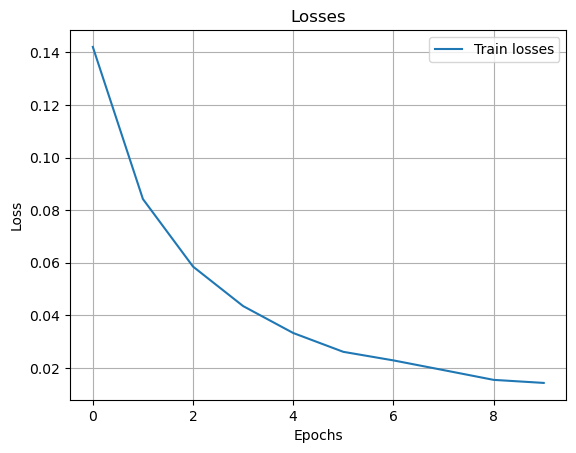

In [58]:
plt.plot(train_losses, label='Train losses')
plt.grid()
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

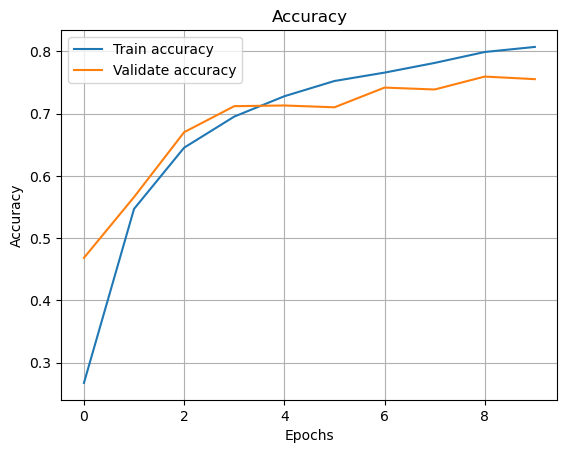

In [59]:
plt.plot(train_accs, label='Train accuracy')
plt.plot(valid_accs, label='Validate accuracy')
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

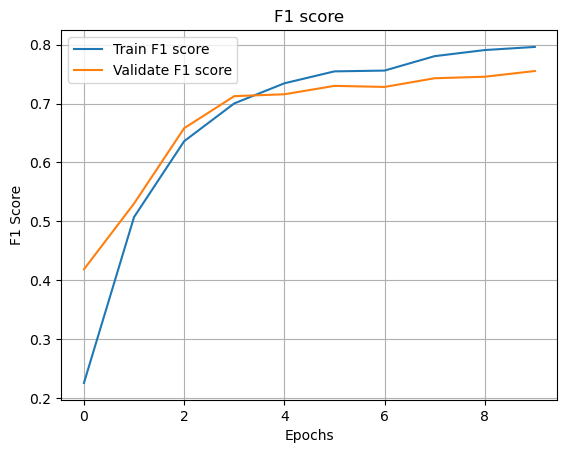

In [60]:
plt.plot(train_f1s, label='Train F1 score')
plt.plot(valid_f1s, label='Validate F1 score')
plt.grid()
plt.title('F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [61]:
torch.save(model, 'final_gru_model.pth')  #Модель и её веса сохраняются для дальнейшего использования, чтобы снова не ждать весь процесс обучения

In [62]:
tokens = list(map(lambda x: vocab.tokenize(x), custom_title))
X = torch.concat(list(map(lambda x: vocab.encode(x)[0], custom_title))).reshape(len(custom_title), -1)
pred = model(X.to(device)).argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 

